Todo: 

* Classifier per hero * role

In [10]:
import os
import json
import numpy as np
import pickle 
import tqdm
import gzip
import tarfile
from scipy import sparse
from collections import defaultdict
from pprint import pprint

In [4]:
# with tarfile.open("../data/parsed/opendota_parsed_matches.tar.gz", 'r:gz') as zfp:
#     for filename in zfp.getnames():
#         match = pickle.load(zfp.extractfile(filename))
#         print(match)
#         break

zfp = tarfile.open("../data/opendota_parsed_matches.tar.gz", 'r:gz')
all_filenames = zfp.getnames()

In [5]:
filenames = all_filenames[1:]

In [6]:
# fp = zfp.extractfile(filenames[0])
# fp.seek(0)
# match = pickle.loads(fp.read())

In [183]:
def get_rank(rank: int):
    oh = np.zeros(5)
    oh[rank] = 1
    return oh

def kda(kills, deaths, assists):
    return kills + assists / (deaths + 1)

def extract_data_point(match):
    players = match["players"]
    t0 = list(filter(lambda p: p["isRadiant"], players))
    t1 = list(filter(lambda p: not p["isRadiant"], players))
    xs = []
    ys = []
    for team in [t0, t1]:
        hids = [p["hero_id"] for p in team]

        # !Ranks
        attributes = ["gold_per_min", "xp_per_min", "kills", "deaths", "assists", "last_hits", "hero_damage", "tower_damage"]
        ranks = {}
        
        for attr in attributes:
            ranks[attr] = sorted([(p["hero_id"], p[attr]) for p in team], key=lambda x: x[1], reverse=True)
        
        # wards_used = sorted([(p["hero_id"], p["sentry_uses"]) for p in team], key=lambda x: x[1], reverse=True)

        wards_placed = {}
        for p in team:
            item_uses = p["item_uses"]
            c = 0
            if "ward_observer" in item_uses:
                c += item_uses["ward_observer"]
            if "ward_dispenser" in item_uses:
                c += item_uses["ward_dispenser"]
            if "ward_sentry" in item_uses:
                c += item_uses["ward_sentry"]
                
            wards_placed[p["hero_id"]] = c
            # wards_placed.append((p["hero_id"], c))
        # wards_placed = sorted(wards_placed, key=lambda x: x[1], reverse=True)
        # !Find roles

        support_candidates_4 = []
        support_candidates_5 = []
        unassigned_candidates = []
        final_roles = {}
        lanes = defaultdict(list)
        players = defaultdict(dict)
        for p in team:
            lanes[p["lane"]].append({"hid": p["hero_id"], "gpm": p["gold_per_min"], "wards": wards_placed[p["hero_id"]]})
            players[p["hero_id"]] = {"gpm": p["gold_per_min"], "wards": wards_placed[p["hero_id"]]}
        

        for lane in lanes.items():
            if len(lane[1]) == 5:
                return "invalid_match", None

        # for p in lanes[1]:
        if len(lanes[1]) > 1:
            highest_gpm_hero = max(lanes[1], key=lambda x: x["gpm"])
            everyone_except_highest_gpm_hero_id = [x["hid"] for x in lanes[1] if x["hid"] != highest_gpm_hero["hid"]]
            support_candidates_5.extend(everyone_except_highest_gpm_hero_id)
            final_roles[1] = highest_gpm_hero["hid"]
        elif len(lanes[1]) == 1:
            final_roles[1] = lanes[1][0]["hid"]
            
        # for p in lanes[2]:
        if len(lanes[2]) > 1:
            highest_gpm_hero = max(lanes[2], key=lambda x: x["gpm"])
            everyone_except_highest_gpm_hero_id = [x["hid"] for x in lanes[2] if x["hid"] != highest_gpm_hero["hid"]]
            support_candidates_4.extend(everyone_except_highest_gpm_hero_id)
            final_roles[2] = highest_gpm_hero["hid"]
        elif len(lanes[2]) == 1:
            final_roles[2] = lanes[2][0]["hid"]

        # for p in lanes[3]:
        if len(lanes[3]) > 1:
            highest_gpm_hero = max(lanes[3], key=lambda x: x["gpm"])
            everyone_except_highest_gpm_hero_id = [x["hid"] for x in lanes[3] if x["hid"] != highest_gpm_hero["hid"]]
            support_candidates_4.extend(everyone_except_highest_gpm_hero_id)
            final_roles[3] = highest_gpm_hero["hid"]
        elif len(lanes[3]) == 1:
            final_roles[3] = lanes[3][0]["hid"]

        # for p in lanes[4]:
        all_hero_ids = [x["hid"] for x in lanes[4]]
        support_candidates_4.extend(all_hero_ids)
        
        # for p in lanes[5]:
        all_hero_ids = [x["hid"] for x in lanes[5]]
        support_candidates_5.extend(all_hero_ids)

        # ! Assign pos 4 and 5
        support_candidates_4 = list(set(support_candidates_4))
        support_candidates_5 = list(set(support_candidates_5))

        if len(support_candidates_5) > 1:
            support_candidates_5_wards_max = max(support_candidates_5, key=lambda x: wards_placed[x])
            final_roles[5] = support_candidates_5_wards_max
            unassigned_candidates.extend([x for x in support_candidates_5 if x != support_candidates_5_wards_max])
        elif len(support_candidates_5) == 1: 
            final_roles[5] = support_candidates_5[0]

        if len(support_candidates_4) > 1:
            support_candidates_4_wards_min = min(support_candidates_4, key=lambda x: wards_placed[x])
            final_roles[4] = support_candidates_4_wards_min
            unassigned_candidates.extend([x for x in support_candidates_4 if x != support_candidates_4_wards_min])
        elif len(support_candidates_4) == 1:
            final_roles[4] = support_candidates_4[0]

        # ! check if all roles are assigned

        unassigned_candidates = list(set(unassigned_candidates))
        for role in lanes:
            if role not in final_roles:
                if len(unassigned_candidates) == 1:
                    final_roles[role] = unassigned_candidates[0]
                    unassigned_candidates.pop()
                    # print("Assigned {} to role {}".format(final_roles[role], role))
                elif len(unassigned_candidates) > 1:
                    unassigned_candidates_gpm_wards = [(x, players[x]["gpm"], players[x]["wards"]) for x in unassigned_candidates]
                    final_roles_gpm_wards = [(x, players[x]["gpm"], players[x]["wards"]) for x in final_roles.values()]
                    if role == 1: 
                        max_gpm_hero = max(unassigned_candidates, key=lambda x: players[x]["gpm"])
                        final_roles[role] = max_gpm_hero
                        unassigned_candidates.pop(unassigned_candidates.index(max_gpm_hero))
                        print("Role {} not assigned. Assigning {}, which has {}. {}".format(role, max_gpm_hero, players[max_gpm_hero], unassigned_candidates_gpm_wards))
                        print(final_roles_gpm_wards)

                    elif role == 5: 
                        max_wards_hero = max(unassigned_candidates, key=lambda x: wards_placed[x])
                        final_roles[role] = max_wards_hero
                        unassigned_candidates.pop(unassigned_candidates.index(max_wards_hero))
                        print("Role {} not assigned. Assigning {}, which has {}. {}".format(role, max_wards_hero, players[max_wards_hero], unassigned_candidates_gpm_wards))
                        print(final_roles_gpm_wards)

                    elif role == 3:
                        max_gpm_hero = max(unassigned_candidates, key=lambda x: players[x]["gpm"])
                        final_roles[role] = max_gpm_hero
                        unassigned_candidates.pop(unassigned_candidates.index(max_gpm_hero))
                        print("Role {} not assigned. Assigning {}, which has {}. {}".format(role, max_gpm_hero, players[max_gpm_hero], unassigned_candidates_gpm_wards))
                        print(final_roles_gpm_wards)
                else:
                    raise Exception("No more heroes to assign")
            
        # if len(unassigned_candidates) > 2:
        #     print(unassigned_candidates)
        #     pprint(lanes)
        #     print("final roles: ", final_roles)
        #     print("support candidates 4: ", support_candidates_4)
        #     print("support candidates 5: ", support_candidates_5)
        #     print("wards placed: ", wards_placed)
        #     raise Exception("Too many unassigned candidates")

        if len(final_roles) != 5:
            print("final roles: ", final_roles)
            print("support candidates 4: ", support_candidates_4)
            print("support candidates 5: ", support_candidates_5)
            print("wards placed: ", wards_placed)
            raise Exception("Not all roles assigned")


        # !Add features
        for p in team:
            features = []
            hid = p["hero_id"]
            
            onehot_hero = np.zeros((136))
            onehot_hero[hid] = 1.
            features.append(onehot_hero)

            teammates = np.zeros((136))
            for team_hid in hids:
                if team_hid != hid:
                    teammates[team_hid] = 1.
            
            features.append(teammates)
            
            for rank in ranks: 
                features.append(get_rank(ranks[rank].index((hid, p[rank]))))


            #! Add labels
            
            flipped_final_roles = {v: k for k, v in final_roles.items()}
            position = flipped_final_roles[hid]                
            
            xs.append(np.concatenate(features))
            ys.append(position)

    return xs, ys



# !Main loop
trainingset = []
labels = []
skips = 0
for fname in tqdm.tqdm(filenames[6400: 7000]):
    leaver = False
    fp = zfp.extractfile(fname)
    fp.seek(0)
    match = pickle.loads(fp.read())
    xs, ys = extract_data_point(match)
    if xs == "invalid_match":
        skips += 1
        continue
    trainingset.append(np.vstack(xs))
    labels.append(ys)
    
print("skips", skips)

x = np.vstack(trainingset)
y = np.concatenate(labels).ravel()    

  9%|▉         | 55/600 [00:03<00:19, 27.29it/s]

Role 1 not assigned. Assigning 6, which has {'gpm': 153, 'wards': 0}. [(4, 143, 2), (6, 153, 0)]
[(36, 159, 0), (11, 613, 0), (108, 120, 0)]
Role 3 not assigned. Assigning 86, which has {'gpm': 835, 'wards': 12}. [(86, 835, 12), (14, 745, 5)]
[(105, 685, 24), (44, 886, 0), (106, 850, 0)]
Role 3 not assigned. Assigning 10, which has {'gpm': 380, 'wards': 0}. [(64, 297, 0), (10, 380, 0)]
[(104, 360, 0), (1, 392, 6), (111, 274, 39)]


 30%|███       | 182/600 [00:04<00:03, 133.26it/s]

Role 3 not assigned. Assigning 99, which has {'gpm': 798, 'wards': 1}. [(33, 421, 1), (99, 798, 1)]
[(84, 747, 0), (35, 1982, 1), (74, 1125, 0)]


 77%|███████▋  | 461/600 [00:06<00:00, 155.52it/s]

Role 1 not assigned. Assigning 16, which has {'gpm': 412, 'wards': 2}. [(16, 412, 2), (54, 297, 2)]
[(71, 760, 0), (100, 464, 0), (30, 299, 0)]
Role 1 not assigned. Assigning 60, which has {'gpm': 557, 'wards': 2}. [(60, 557, 2), (4, 329, 0)]
[(10, 1779, 2), (101, 363, 1), (89, 327, 0)]


100%|██████████| 600/600 [00:07<00:00, 84.96it/s] 

skips 1


[1 2 3 4 5] [19982 19982 19982 19982 19982]


<AxesSubplot:ylabel='Frequency'>

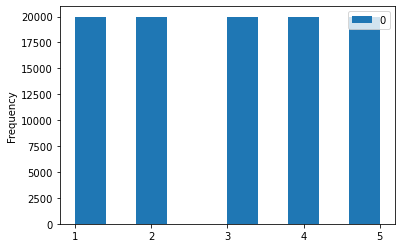

In [169]:
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)
import pandas as pd

df = pd.DataFrame(y)
df.plot.hist(xticks=[1, 2, 3, 4, 5])

In [170]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(np.mean(y_pred == y_test))

print(confusion_matrix(y_test, y_pred))

0.4391452307076369
[[1786 1700  119   75  250]
 [ 669 3129   27   54  131]
 [1806 1830  121   82  246]
 [ 229   78    8  336 3363]
 [ 170   71    1  298 3403]]


In [171]:
from sklearn.linear_model import LogisticRegression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=0)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(np.mean(y_pred == y_test))

print(confusion_matrix(y_test, y_pred))

0.527474727254529
[[1702  427 1566  116  119]
 [ 275 3410  202   67   56]
 [1734  448 1676  127  100]
 [ 138   86  154 1585 2051]
 [ 120   59   95 1502 2167]]


/home/bao/anaconda3/envs/dota/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split


# for hero, train a logistic regression model and add to VotingClassifier
estimators = []


clf = LogisticRegression(multi_class='multinomial', random_state=1)

eclf1 = VotingClassifier(estimators=estimators, voting='hard')
eclf1 = eclf1.fit(x_train, y_train)

ValueError: Invalid 'estimators' attribute, 'estimators' should be a list of (string, estimator) tuples.

In [ ]:
print(eclf1.predict(x_test))

NameError: name 'eclf1' is not defined

In [ ]:
np.array_equal(eclf1.named_estimators_.lr.predict(x), eclf1.named_estimators_['lr'].predict(x))

NameError: name 'np' is not defined